# scGPT

In [1]:
import warnings
from pathlib import Path
import scanpy as sc
import scgpt as scg
import numpy as np
import pandas as pd
import torch

import os
import pickle

import subprocess
import sys

from scgpt.tasks import embed_data

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from collections import Counter

warnings.filterwarnings("ignore")

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

C:\Users\fbrit\miniconda3\envs\crispr\lib\site-packages\scgpt\model\model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
C:\Users\fbrit\miniconda3\envs\crispr\lib\site-packages\scgpt\model\multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
C:\Users\fbrit\miniconda3\envs\crispr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.2.0+cu121
CUDA available: True
CUDA device: NVIDIA RTX 4000 Ada Generation Laptop GPU


In [2]:
adata_path = "fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad"
adata = sc.read_h5ad(adata_path)

print(adata)
print("Layers available:", adata.layers.keys())

AnnData object with n_obs × n_vars = 220403 × 30395
    obs: 'dataset', 'UMI_count', 'guide_identity', 'guide_umi_count', 'thresholded_features', 'thresholded_guide_umi', 'num_cells', 'guide_target', 'gem_group', 'mt_frac', 'keep', 'single_cell', 'control', 'pairwise_coef', 'pairwise_UMI_count', 'pairwise_singlet_equivalent_UMI_count', 'final_pairwise_UMI_count', 'protospacer'
    var: 'gene_name', 'feature_types', 'genome', 'mean', 'in_matrix', 'std', 'cv', 'fano', 'pairwise_p_cost', 'mean_adjusted_pairwise_p_cost', 'excess_cv', 'pairwise_chosen'
    uns: 'log1p'
    layers: 'counts'
Layers available: KeysView(Layers with keys: counts)


In [5]:
perturbed = adata.obs.loc[~adata.obs['control'], 'guide_target'].unique()
len(perturbed)

1837

Subsampling the controls for balance.

In [28]:
def balance_by_stratified_sampling(adata_path, target_col='guide_target', 
                                   control_label='non',
                                   max_cells_per_target=None, 
                                   min_cells_per_target=50,
                                   n_clusters_for_controls=20,
                                   random_state=42, 
                                   strategy='median',
                                   show_clusters=True):
    """
    Balance dataset using stratified sampling for controls.
    Controls are first clustered, then sampled proportionally from each cluster
    to preserve diversity, matching the size of non-control targets.
    
    Parameters:
    -----------
    adata_path : str
        Path to input AnnData file
    target_col : str
        Column name in obs containing target identities
    control_label : str
        Label used for control/non-targeting cells
    max_cells_per_target : int, optional
        Maximum cells to keep per target. If None, calculated from non-control targets
    min_cells_per_target : int
        Minimum cells required per target
    n_clusters_for_controls : int
        Number of clusters to use when stratifying control cells
    random_state : int
        Random seed for reproducibility
    strategy : str
        Strategy for determining max_cells_per_target (applied to non-controls only):
        'median', 'mean', 'min', 'percentile_25'
    show_clusters : bool
        If True, visualize the control cell clusters used for stratification
    
    Returns:
    --------
    adata_balanced : AnnData
        Downsampled AnnData object
    """
    
    # Generate output filename (save in current directory)
    input_filename = os.path.basename(adata_path)
    base_name = input_filename.rsplit('.h5ad', 1)[0]
    output_filename = f"{base_name}_stratified.h5ad"
    
    # Check if balanced file already exists
    if os.path.exists(output_filename):
        print(f"✓ Found existing stratified file: {output_filename}")
        print("Loading existing balanced dataset...")
        adata_balanced = sc.read_h5ad(output_filename)
        return adata_balanced
    
    # Load original data
    print(f"Loading data from: {adata_path}")
    adata = sc.read_h5ad(adata_path)
    
    if target_col not in adata.obs.columns:
        raise ValueError(f"Column '{target_col}' not found in adata.obs")
    
    target_counts = adata.obs[target_col].value_counts()
    
    print("="*60)
    print("STRATIFIED DATASET BALANCING")
    print("="*60)
    print(f"Original dataset: {len(adata)} cells, {len(target_counts)} targets")
    
    # Remove targets with too few cells
    targets_to_keep = target_counts[target_counts >= min_cells_per_target].index
    targets_removed = target_counts[target_counts < min_cells_per_target]
    
    if len(targets_removed) > 0:
        print(f"\nRemoving {len(targets_removed)} targets with < {min_cells_per_target} cells:")
        for target, count in targets_removed.items():
            print(f"  - {target}: {count} cells")
    
    adata_filtered = adata[adata.obs[target_col].isin(targets_to_keep)].copy()
    target_counts_filtered = adata_filtered.obs[target_col].value_counts()
    
    # ===== KEY FIX: Calculate max_cells_per_target from NON-CONTROL targets only =====
    if max_cells_per_target is None:
        # Get non-control target counts
        non_control_counts = target_counts_filtered[target_counts_filtered.index != control_label]
        
        if len(non_control_counts) == 0:
            raise ValueError("No non-control targets found!")
        
        if strategy == 'median':
            max_cells_per_target = int(non_control_counts.median())
        elif strategy == 'mean':
            max_cells_per_target = int(non_control_counts.mean())
        elif strategy == 'min':
            max_cells_per_target = int(non_control_counts.min())
        elif strategy == 'percentile_25':
            max_cells_per_target = int(non_control_counts.quantile(0.25))
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
        
        print(f"\n📊 Non-control target statistics:")
        print(f"   Min: {non_control_counts.min()}, Max: {non_control_counts.max()}")
        print(f"   Mean: {non_control_counts.mean():.1f}, Median: {non_control_counts.median():.1f}")
        print(f"\n✓ Using strategy '{strategy}' on non-controls: max_cells_per_target = {max_cells_per_target}")
    else:
        print(f"\nUsing specified max_cells_per_target = {max_cells_per_target}")
    
    np.random.seed(random_state)
    indices_to_keep = []
    
    print(f"\nDownsampling targets:")
    
    # Separate controls from perturbations
    control_mask = adata_filtered.obs[target_col] == control_label
    perturbed_targets = [t for t in target_counts_filtered.index if t != control_label]
    
    # Handle control cells with stratified sampling
    if control_mask.sum() > 0:
        adata_controls = adata_filtered[control_mask].copy()
        n_control_cells = len(adata_controls)
        
        if n_control_cells > max_cells_per_target:
            print(f"\n  {control_label}: {n_control_cells} cells")
            print(f"    → Performing stratified sampling to preserve diversity...")
            
            # Cluster control cells to identify subpopulations
            # Use PCA for speed if data is large
            if adata_controls.X.shape[1] > 2000:
                pca = PCA(n_components=50, random_state=random_state)
                X_reduced = pca.fit_transform(adata_controls.X.toarray() if hasattr(adata_controls.X, 'toarray') else adata_controls.X)
            else:
                X_reduced = adata_controls.X.toarray() if hasattr(adata_controls.X, 'toarray') else adata_controls.X
            
            # Cluster
            kmeans = MiniBatchKMeans(n_clusters=n_clusters_for_controls, 
                                    random_state=random_state, 
                                    batch_size=1000)
            control_clusters = kmeans.fit_predict(X_reduced)
            
            # Visualize clusters if requested
            if show_clusters:
                print(f"    → Visualizing {n_clusters_for_controls} control clusters...")
                
                # Compute UMAP for visualization
                adata_controls.obsm['X_reduced'] = X_reduced
                sc.pp.neighbors(adata_controls, use_rep='X_reduced', n_neighbors=15)
                sc.tl.umap(adata_controls)
                adata_controls.obs['control_cluster'] = pd.Categorical(control_clusters.astype(str))
                
                # Plot
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                
                # Cluster assignments
                sc.pl.umap(adata_controls, color='control_cluster', ax=ax1, show=False,
                          title=f'Control Cell Clusters (K={n_clusters_for_controls})',
                          legend_loc='right margin', frameon=False)
                
                # Cluster sizes
                cluster_sizes = pd.Series(control_clusters).value_counts().sort_index()
                ax2.bar(cluster_sizes.index, cluster_sizes.values, color='steelblue')
                ax2.set_xlabel('Cluster ID', fontsize=12)
                ax2.set_ylabel('Number of Cells', fontsize=12)
                ax2.set_title('Cluster Sizes', fontsize=12, fontweight='bold')
                ax2.grid(axis='y', alpha=0.3)
                
                plt.tight_layout()
                cluster_plot_path = f"{base_name}_control_clusters.png"
                plt.savefig(cluster_plot_path, dpi=300, bbox_inches='tight')
                print(f"    ✓ Saved cluster visualization: {cluster_plot_path}")
                plt.show()
            
            # Sample proportionally from each cluster
            selected_control_indices = []
            for cluster_id in range(n_clusters_for_controls):
                cluster_indices = np.where(control_clusters == cluster_id)[0]
                n_cluster_cells = len(cluster_indices)
                
                # Proportional sampling
                n_to_sample = int(np.ceil(max_cells_per_target * n_cluster_cells / n_control_cells))
                n_to_sample = min(n_to_sample, n_cluster_cells)  # Can't sample more than available
                
                sampled = np.random.choice(cluster_indices, size=n_to_sample, replace=False)
                selected_control_indices.extend(sampled)
            
            # Ensure we don't exceed max_cells_per_target
            if len(selected_control_indices) > max_cells_per_target:
                selected_control_indices = np.random.choice(selected_control_indices, 
                                                           size=max_cells_per_target, 
                                                           replace=False)
            
            # Convert to global indices
            control_global_indices = np.where(control_mask)[0][selected_control_indices]
            indices_to_keep.extend(control_global_indices)
            
            print(f"    → Sampled {len(selected_control_indices)} cells from {n_clusters_for_controls} clusters")
        else:
            # Keep all control cells
            indices_to_keep.extend(np.where(control_mask)[0])
            print(f"\n  {control_label}: {n_control_cells} cells (kept all)")
    
    # Handle perturbed targets with simple random sampling
    for target in perturbed_targets:
        target_mask = adata_filtered.obs[target_col] == target
        target_indices = np.where(target_mask)[0]
        n_cells = len(target_indices)
        
        if n_cells > max_cells_per_target:
            selected_indices = np.random.choice(target_indices, size=max_cells_per_target, replace=False)
            indices_to_keep.extend(selected_indices)
            print(f"  {target}: {n_cells} → {max_cells_per_target} cells")
        else:
            indices_to_keep.extend(target_indices)
            print(f"  {target}: {n_cells} cells (kept all)")
    
    # Create balanced dataset
    adata_balanced = adata_filtered[indices_to_keep].copy()
    
    print(f"\nBalanced dataset: {len(adata_balanced)} cells")
    print(f"Reduction: {len(adata)} → {len(adata_balanced)} ({len(adata_balanced)/len(adata)*100:.1f}%)")
    
    # Visualize before/after distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Original distribution (top 20)
    target_counts_orig = adata.obs[target_col].value_counts().sort_values(ascending=True).head(20)
    target_counts_orig.plot(kind='barh', ax=ax1, color='coral')
    ax1.set_xlabel('Number of Cells', fontsize=12)
    ax1.set_ylabel('Guide Target', fontsize=12)
    ax1.set_title(f'Original Distribution (n={len(adata)})', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Balanced distribution (top 20)
    target_counts_bal = adata_balanced.obs[target_col].value_counts().sort_values(ascending=True).head(20)
    target_counts_bal.plot(kind='barh', ax=ax2, color='steelblue')
    ax2.set_xlabel('Number of Cells', fontsize=12)
    ax2.set_ylabel('Guide Target', fontsize=12)
    ax2.set_title(f'Balanced Distribution (n={len(adata_balanced)})', fontsize=14, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    comparison_path = f"{base_name}_distribution_comparison.png"
    plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved distribution comparison: {comparison_path}")
    plt.show()
    
    # Save balanced dataset
    print(f"\n💾 Saving balanced dataset to: {output_filename}")
    adata_balanced.write(output_filename)
    print("✓ Saved successfully")
    
    print("="*60 + "\n")
    
    return adata_balanced

Loading data from: fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad
STRATIFIED DATASET BALANCING
Original dataset: 220403 cells, 1837 targets

Removing 45 targets with < 50 cells:
  - ZNF630: 49 cells
  - ZNF398: 49 cells
  - LHX5: 49 cells
  - KLF9: 49 cells
  - RHOXF2: 49 cells
  - CDK1: 49 cells
  - ZNF837: 48 cells
  - ZSCAN9: 48 cells
  - NANOGNB: 48 cells
  - RORC: 48 cells
  - ZNF525: 47 cells
  - ZKSCAN3: 47 cells
  - NOTCH2: 46 cells
  - TP53: 46 cells
  - ZNF493: 46 cells
  - HMGB2: 46 cells
  - ARID4A: 45 cells
  - FLI1: 45 cells
  - DNAJC2: 45 cells
  - ZBTB9: 44 cells
  - ZNF831: 44 cells
  - ZNF85: 43 cells
  - GTF2H2: 43 cells
  - TSC22D3: 43 cells
  - ZNF91: 42 cells
  - HOXC13: 42 cells
  - ZNF845: 42 cells
  - ZNF827: 41 cells
  - IL18: 40 cells
  - PLAG1: 40 cells
  - ASCL1: 39 cells
  - GATA6: 39 cells
  - PSMD14: 38 cells
  - ZNF287: 38 cells
  - ZNF20: 37 cells
  - MEF2C: 37 cells
  - HNRNPAB: 36 cells
  - ZNF691: 36 cells
  - ZNF75D: 35 cells
  - HOXC6

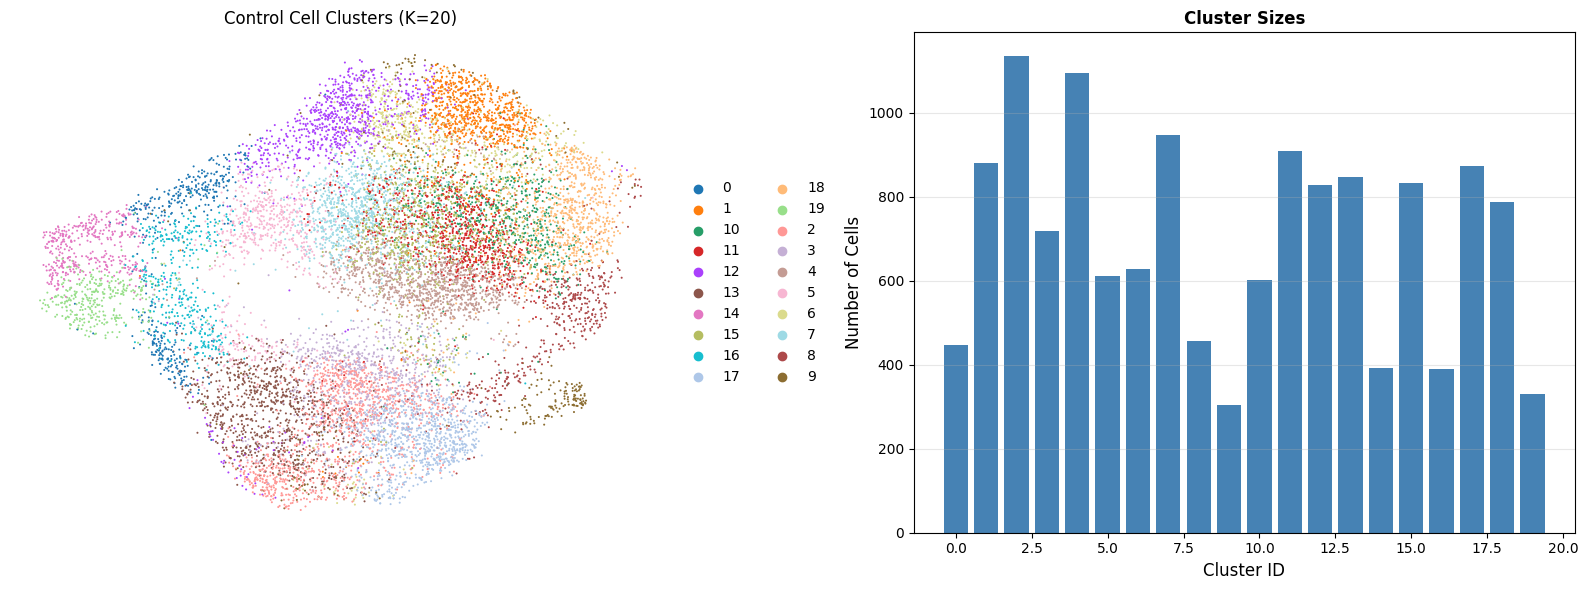

    → Sampled 107 cells from 20 clusters
  ZBTB46: 341 → 107 cells
  JDP2: 331 → 107 cells
  REPIN1: 317 → 107 cells
  FOXD2: 307 → 107 cells
  LHX3: 290 → 107 cells
  ZNF789: 287 → 107 cells
  ELK3: 284 → 107 cells
  HMX1: 280 → 107 cells
  ZNF770: 274 → 107 cells
  RXRA: 273 → 107 cells
  SALL3: 270 → 107 cells
  FOXL2: 263 → 107 cells
  CAPN15: 263 → 107 cells
  AHRR: 263 → 107 cells
  LIN9: 259 → 107 cells
  NFIL3: 255 → 107 cells
  ZNF606: 247 → 107 cells
  TFAP4: 243 → 107 cells
  ARID3A: 242 → 107 cells
  GATA1: 239 → 107 cells
  CLOCK: 237 → 107 cells
  ZSCAN4: 234 → 107 cells
  HMX2: 231 → 107 cells
  MTA1: 231 → 107 cells
  MAPK8IP1: 230 → 107 cells
  ZMIZ2: 229 → 107 cells
  ZFP14: 229 → 107 cells
  FOSB: 228 → 107 cells
  FOXK1: 228 → 107 cells
  HEY2: 228 → 107 cells
  YAP1: 228 → 107 cells
  HIC1: 227 → 107 cells
  REST: 227 → 107 cells
  GZF1: 225 → 107 cells
  GFI1: 223 → 107 cells
  ZKSCAN2: 223 → 107 cells
  SMAD3: 222 → 107 cells
  ZNF507: 222 → 107 cells
  IRX4: 219

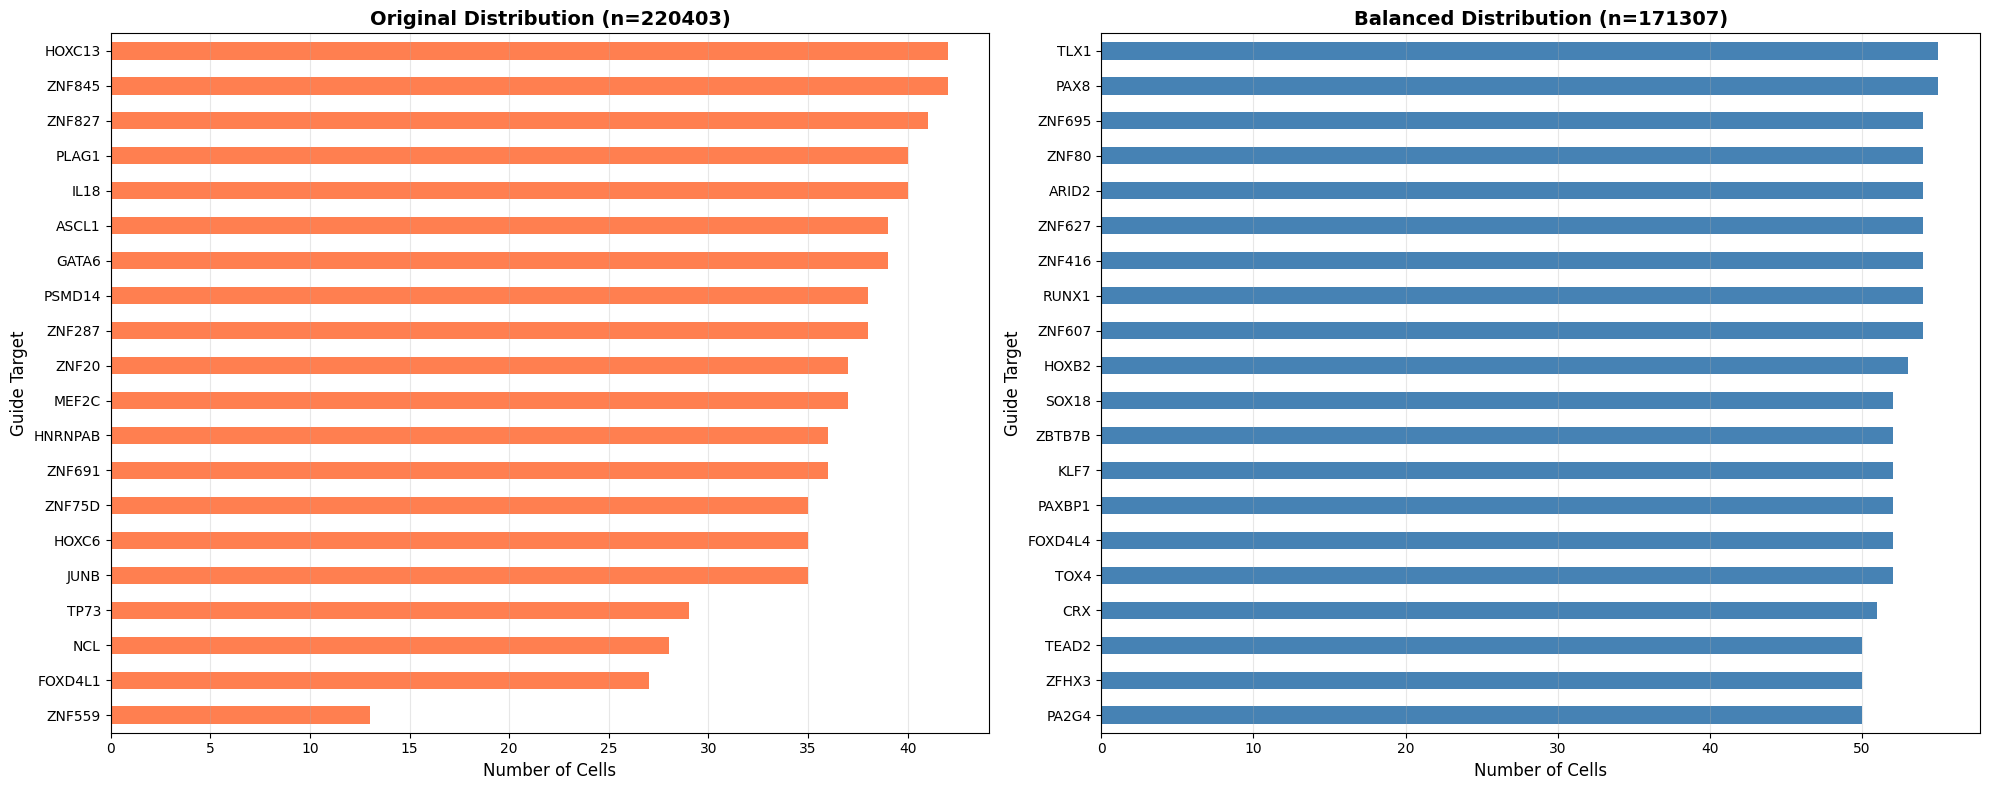


💾 Saving balanced dataset to: fibroblast_CRISPRa_final_pop_singlets_normalized_log1p_stratified.h5ad
✓ Saved successfully



In [29]:
adata_balanced = balance_by_stratified_sampling(
    adata_path="fibroblast_CRISPRa_final_pop_singlets_normalized_log1p.h5ad",
    target_col='guide_target',
    control_label='non',
    strategy='median',
    n_clusters_for_controls=20,
    min_cells_per_target=50,
    random_state=42,
    show_clusters=True
)

We will study the highly variable genes (HVGs), as they are the most likely to contain biological information, and for computational efficiency. The 'standard' version will include those statistically variable genes, whereas the 'force' version will include the target genes even though they aren't part of the 3000 HVGs.

In [37]:
# Select the number of highly variable genes
N_HVG = 3000

# Standard doesn't include the gene that was perturbed, whereas force does
hvg_standard_file = f"adata_balanced_hvg_standard_{N_HVG}.h5ad"
hvg_force_file = f"adata_balanced_hvg_force_{N_HVG}.h5ad"

# Check if both files exist
if os.path.exists(hvg_standard_file) and os.path.exists(hvg_force_file):
    print(f"Loading pre-computed HVG files...")
    adata_hvg_standard = sc.read_h5ad(hvg_standard_file)
    adata_hvg_force = sc.read_h5ad(hvg_force_file)
    print(f"Standard HVGs (no forced targets): {adata_hvg_standard.shape[1]}")
    print(f"HVGs with all guide targets included: {adata_hvg_force.shape[1]}")
else:
    print("Computing HVGs...")
    
    # Standard HVG selection
    sc.pp.highly_variable_genes(adata_balanced, n_top_genes=N_HVG, flavor="seurat_v3")
    adata_hvg_standard = adata_balanced[:, adata_balanced.var['highly_variable']].copy()
    print("Standard HVGs (no forced targets):", adata_hvg_standard.shape[1])
    
    # HVG selection with guide targets included
    adata_hvg_force = adata_balanced.copy()
    sc.pp.highly_variable_genes(adata_hvg_force, n_top_genes=N_HVG, flavor="seurat_v3")
    if 'guide_target' in adata_hvg_force.obs.columns:
        targets = adata_hvg_force.obs['guide_target'].unique()
        gene_var_names = adata_hvg_force.var['gene_name'] if 'gene_name' in adata_hvg_force.var.columns else adata_hvg_force.var.index
        targets_in_var = [g for g in targets if g in gene_var_names.values]
        adata_hvg_force.var.loc[adata_hvg_force.var.index.isin(targets_in_var), 'highly_variable'] = True
    adata_hvg_force = adata_hvg_force[:, adata_hvg_force.var['highly_variable']].copy()
    print("HVGs with all guide targets included:", adata_hvg_force.shape[1])
    
    # Save the computed results
    print(f"Saving HVG results...")
    adata_hvg_standard.write(hvg_standard_file)
    adata_hvg_force.write(hvg_force_file)
    print(f"Saved: {hvg_standard_file} and {hvg_force_file}")

Computing HVGs...
Standard HVGs (no forced targets): 3000
HVGs with all guide targets included: 3000
Saving HVG results...
Saved: adata_balanced_hvg_standard_3000.h5ad and adata_balanced_hvg_force_3000.h5ad


In [38]:
MODEL_DIR = Path("./scGPT_human")
MODEL_DIR.mkdir(exist_ok=True)

# Check if vocab.json exists — if yes, assume checkpoint is already present
if (MODEL_DIR / "vocab.json").exists():
    print("Pretrained scGPT already downloaded in", MODEL_DIR)
else:
    print("Downloading pretrained scGPT to", MODEL_DIR)
    # install/update gdown if not present
    try:
        import gdown
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "gdown"])
        import gdown

    # Google Drive folder URL
    gdrive_url = "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y"
    gdown.download_folder(gdrive_url, output=str(MODEL_DIR), quiet=False, use_cookies=True)

    # Sanity check
    if not (MODEL_DIR / "vocab.json").exists():
        # sometimes it downloads into a nested folder; find it
        nested = list(MODEL_DIR.glob("**/vocab.json"))
        if nested:
            MODEL_DIR = nested[0].parent
            print("Found vocab.json in nested folder:", MODEL_DIR)
        else:
            raise FileNotFoundError("vocab.json not found after download. Please check the Google Drive link.")
    else:
        print("Pretrained scGPT downloaded successfully to", MODEL_DIR)

Pretrained scGPT already downloaded in scGPT_human


Computing the embeddings using the pre-trained scGPT model.

In [39]:
import platform
if platform.system() == "Windows":
    import os, sys
    # 1) Make sched_getaffinity exist and return empty, so len(...) == 0
    #    (scGPT uses len(os.sched_getaffinity(0)) to pick num_workers)
    os.sched_getaffinity = lambda pid=0: set()

    # 2) Monkey-patch DataLoader to force single-process behavior
    #    This ensures num_workers is always 0 and pin_memory=False (safe for CPU/Windows).
    from types import SimpleNamespace
    try:
        import torch
        import torch.utils.data as _tud
        _orig_DataLoader = _tud.DataLoader

        class _SingleProcessDataLoader(_orig_DataLoader):
            def __init__(self, *args, **kwargs):
                # force no multiprocessing workers
                kwargs['num_workers'] = 0
                # pin_memory True is for CUDA; keep it False to be safe on Windows CPU runs
                kwargs.setdefault('pin_memory', False)
                super().__init__(*args, **kwargs)

        _tud.DataLoader = _SingleProcessDataLoader
        # Also patch the symbol where scGPT might import DataLoader directly
        import torch.utils
        torch.utils.data.DataLoader = _tud.DataLoader

        print("Windows patch applied: sched_getaffinity -> empty, DataLoader -> single-process")
    except Exception as e:
        # torch may not be imported yet; that's fine — we'll ensure patch after torch import.
        print("Windows patch partially applied (torch not yet importable). Will attempt DataLoader patch after torch import.")
        # arrange to patch later if torch isn't importable now
        def _deferred_patch():
            import torch.utils.data as _tud2
            _orig_DataLoader2 = _tud2.DataLoader
            class _SingleProcessDataLoader2(_orig_DataLoader2):
                def __init__(self, *args, **kwargs):
                    kwargs['num_workers'] = 0
                    kwargs.setdefault('pin_memory', False)
                    super().__init__(*args, **kwargs)
            _tud2.DataLoader = _SingleProcessDataLoader2
            import torch.utils
            torch.utils.data.DataLoader = _tud2.DataLoader
            print("Deferred DataLoader patch applied.")
        # attach so user can call after torch becomes available
        sys.modules.setdefault('_deferred_scgpt_loader_patch', SimpleNamespace(apply=_deferred_patch))

Windows patch applied: sched_getaffinity -> empty, DataLoader -> single-process


In [40]:
def embed_and_save(adata_obj, model_dir, out_path, batch_size=32, ref_embed_path=None, force_recompute=False):
    """
    Embed data with scGPT and save, with optional caching.
    
    Parameters:
    -----------
    adata_obj : AnnData
        Input data to embed
    model_dir : str
        Path to scGPT model directory
    out_path : str
        Where to save the embedded result
    batch_size : int
        Batch size for embedding
    ref_embed_path : str, optional
        Path to existing ref_embed file to check/load
    force_recompute : bool
        If True, recompute even if cached file exists
    """
    
    # Check if we should load existing embeddings
    if ref_embed_path and os.path.exists(ref_embed_path) and not force_recompute:
        print(f"Found existing embedding file: {ref_embed_path}")
        print("Loading and validating...")
        
        try:
            ref_embed = sc.read_h5ad(ref_embed_path)
            
            # Validation checks
            valid = True
            validation_msgs = []
            
            # Check 1: Has embeddings
            if "X_scGPT" not in ref_embed.obsm:
                validation_msgs.append("❌ Missing 'X_scGPT' in obsm")
                valid = False
            else:
                validation_msgs.append(f"✓ Found embeddings: {ref_embed.obsm['X_scGPT'].shape}")
            
            # Check 2: Same number of cells
            if ref_embed.shape[0] != adata_obj.shape[0]:
                validation_msgs.append(f"❌ Cell count mismatch: {ref_embed.shape[0]} vs {adata_obj.shape[0]}")
                valid = False
            else:
                validation_msgs.append(f"✓ Cell count matches: {ref_embed.shape[0]}")
            
            # Check 3: Expected obs columns present
            expected_cols = [col for col in ['guide_target','guide_identity','control','gem_group','guide_umi_count']
                           if col in adata_obj.obs.columns]
            missing_cols = [col for col in expected_cols if col not in ref_embed.obs.columns]
            if missing_cols:
                validation_msgs.append(f"⚠️  Missing obs columns: {missing_cols}")
            else:
                validation_msgs.append(f"✓ All expected obs columns present")
            
            # Print validation results
            print("\nValidation results:")
            for msg in validation_msgs:
                print(f"  {msg}")
            
            if valid:
                print("\n✓ Using cached embeddings!")
                return ref_embed
            else:
                print("\n⚠️  Cached file validation failed. Recomputing embeddings...")
        
        except Exception as e:
            print(f"Error loading cached file: {e}")
            print("Recomputing embeddings...")
    
    # If we get here, we need to compute embeddings
    print("\n" + "="*60)
    print("Computing new embeddings...")
    print("="*60)
    
    # Ensure gene_symbol exists
    if "gene_symbol" not in adata_obj.var.columns:
        adata_obj.var["gene_symbol"] = adata_obj.var["gene_name"]
    
    # Detect device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Columns to keep with embeddings
    cols_to_save = [col for col in ['guide_target','guide_identity','control','gem_group','guide_umi_count']
                    if col in adata_obj.obs.columns]
    print("Saving obs columns with embeddings:", cols_to_save)
    
    # Embed data with scGPT
    ref_embed = embed_data(
        adata_obj,
        model_dir,
        gene_col="gene_symbol",
        obs_to_save=cols_to_save if cols_to_save else None,
        batch_size=batch_size,
        device=device,
        use_fast_transformer=False,
        return_new_adata=True
    )
    
    # Store embeddings in .obsm
    ref_embed.obsm["X_scGPT"] = ref_embed.X.copy()
    print("Embeddings stored in ref_embed.obsm['X_scGPT']")
    
    # Save checkpoint
    ref_embed.write(out_path)
    print("Checkpoint saved:", out_path)
    
    return ref_embed

Some functions for clustering.

In [41]:
def compute_dimensionality_reduction(ref_embed_path, n_neighbors=15, random_state=42, force_recompute=False):
    """
    Compute UMAP for scGPT embeddings (once and saved).
    These are deterministic and don't need recomputation unless forced.
    
    Parameters:
    -----------
    ref_embed_path : str
        Path to the AnnData file with embeddings in .obsm['X_scGPT']
    n_neighbors : int
        Number of neighbors for UMAP computation
    random_state : int
        Random seed for reproducibility
    force_recompute : bool
        If True, recompute even if UMAP already exists
    
    Returns:
    --------
    ref_embed : AnnData
        AnnData with added UMAP
    """
    
    ref_embed = sc.read_h5ad(ref_embed_path)
    
    if 'X_scGPT' not in ref_embed.obsm:
        raise ValueError("No 'X_scGPT' embeddings found in the file!")
    
    # Check what already exists
    has_umap = 'X_umap' in ref_embed.obsm
    
    if has_umap and not force_recompute:
        print("✓ Found existing UMAP")
        return ref_embed
    
    print("Computing UMAP dimensionality reduction...")
    
    # Compute UMAP
    sc.pp.neighbors(ref_embed, use_rep='X_scGPT', n_neighbors=n_neighbors)
    sc.tl.umap(ref_embed)
    print("  ✓ UMAP computed")
    
    # Save results
    ref_embed.write(ref_embed_path)
    print(f"✓ Saved to: {ref_embed_path}")
    
    return ref_embed


def cluster_and_visualize(ref_embed_path, n_clusters=10, random_state=42, output_prefix="embedding_analysis"):
    """
    Cluster embeddings with K-means and visualize on UMAP.
    Clusters are always recomputed (K-dependent), but UMAP is loaded if available.
    
    Parameters:
    -----------
    ref_embed_path : str
        Path to AnnData file with embeddings and (optionally) UMAP
    n_clusters : int
        Number of clusters for K-means
    random_state : int
        Random seed for reproducibility
    output_prefix : str
        Prefix for output plot files
    """
    
    # Load data
    ref_embed = sc.read_h5ad(ref_embed_path)
    
    # Verify UMAP exists (compute if needed)
    if 'X_umap' not in ref_embed.obsm:
        print("UMAP not found. Computing...")
        ref_embed = compute_dimensionality_reduction(ref_embed_path, random_state=random_state)
    
    embeddings = ref_embed.obsm['X_scGPT']
    
    # Always compute K-means clustering
    print(f"Computing K-means with {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    clusters = kmeans.fit_predict(embeddings)
    ref_embed.obs['kmeans_cluster'] = pd.Categorical(clusters.astype(str))
    
    # Determine available metadata
    has_control = 'control' in ref_embed.obs.columns
    has_targets = 'guide_target' in ref_embed.obs.columns
    
    # Prepare guide target categories (top 15 + Other)
    if has_targets:
        top_targets = ref_embed.obs['guide_target'].value_counts().head(15).index
        ref_embed.obs['guide_target_top'] = ref_embed.obs['guide_target'].apply(
            lambda x: x if x in top_targets else 'Other'
        )
        ref_embed.obs['guide_target_top'] = ref_embed.obs['guide_target_top'].astype('category')
    
    # ============================================
    # Main Visualization Figure (UMAP only)
    # ============================================
    n_plots = 1 + (1 if has_control else 0) + (1 if has_targets else 0)
    fig = plt.figure(figsize=(7 * n_plots, 6))
    
    plot_idx = 1
    
    # UMAP: K-means clusters
    ax1 = plt.subplot(1, n_plots, plot_idx)
    sc.pl.umap(ref_embed, color='kmeans_cluster', ax=ax1, show=False, 
               title=f'K-means Clusters (K={n_clusters})', legend_loc='right margin',
               frameon=False)
    plot_idx += 1
    
    # UMAP: Control vs Perturbed
    if has_control:
        ax2 = plt.subplot(1, n_plots, plot_idx)
        sc.pl.umap(ref_embed, color='control', ax=ax2, show=False,
                   title='Control vs Perturbed', legend_loc='right margin',
                   frameon=False)
        plot_idx += 1
    
    # UMAP: Guide targets
    if has_targets:
        ax3 = plt.subplot(1, n_plots, plot_idx)
        sc.pl.umap(ref_embed, color='guide_target_top', ax=ax3, show=False,
                   title='Guide Targets (top 15)', legend_loc='right margin',
                   frameon=False)
    
    plt.tight_layout()
    output_file = f'{output_prefix}_k{n_clusters}_umap.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    plt.show()
    
    # ============================================
    # Cluster Composition Analysis
    # ============================================
    if has_control:
        cluster_composition = pd.crosstab(
            ref_embed.obs['kmeans_cluster'],
            ref_embed.obs['control'],
            normalize='index'
        ) * 100
        
        # Visualize composition
        fig, ax = plt.subplots(figsize=(12, 6))
        cluster_composition.plot(kind='bar', ax=ax, stacked=True, 
                                color=['#3498db', '#e74c3c'])
        ax.set_xlabel('Cluster', fontsize=12)
        ax.set_ylabel('Percentage (%)', fontsize=12)
        ax.set_title(f'Cluster Composition (K={n_clusters})', fontsize=14, fontweight='bold')
        ax.legend(title='Status', fontsize=10)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        plt.tight_layout()
        output_file = f'{output_prefix}_k{n_clusters}_composition.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_file}")
        plt.show()
    
    # ============================================
    # Statistics Summary
    # ============================================
    print("\n" + "="*60)
    print(f"CLUSTERING SUMMARY (K={n_clusters})")
    print("="*60)
    
    # Cluster sizes
    cluster_sizes = ref_embed.obs['kmeans_cluster'].value_counts().sort_index()
    print("\nCluster sizes:")
    for cluster, size in cluster_sizes.items():
        pct = (size / len(ref_embed)) * 100
        print(f"  Cluster {cluster}: {size} cells ({pct:.1f}%)")
    
    if has_control:
        # Silhouette score
        control_numeric = ref_embed.obs['control'].astype(int)
        sil_score = silhouette_score(embeddings, control_numeric)
        print(f"\nSilhouette Score: {sil_score:.3f}", end=" ")
        if sil_score > 0.3:
            print("(Good separation ✓)")
        elif sil_score > 0.1:
            print("(Moderate separation)")
        else:
            print("(Poor separation)")
        
        # Cluster purity
        cluster_purity = []
        for cluster in sorted(ref_embed.obs['kmeans_cluster'].unique()):
            cluster_mask = ref_embed.obs['kmeans_cluster'] == cluster
            cluster_controls = ref_embed.obs.loc[cluster_mask, 'control']
            majority_class = Counter(cluster_controls).most_common(1)[0]
            purity = majority_class[1] / len(cluster_controls)
            cluster_purity.append(purity)
        
        avg_purity = np.mean(cluster_purity)
        print(f"Average Cluster Purity: {avg_purity:.3f}", end=" ")
        if avg_purity > 0.7:
            print("(High purity ✓)")
        elif avg_purity > 0.5:
            print("(Moderate purity)")
        else:
            print("(Low purity)")
        
        # Control/Perturbed distribution
        print(f"\nOverall distribution:")
        control_counts = ref_embed.obs['control'].value_counts()
        for status, count in control_counts.items():
            pct = (count / len(ref_embed)) * 100
            print(f"  {status}: {count} cells ({pct:.1f}%)")
    
    if has_targets:
        print(f"\nTop 10 guide targets:")
        top_10 = ref_embed.obs['guide_target'].value_counts().head(10)
        for target, count in top_10.items():
            pct = (count / len(ref_embed)) * 100
            print(f"  {target}: {count} cells ({pct:.1f}%)")
    
    print("="*60 + "\n")
    
    return ref_embed

### All genes

In [52]:
# For all genes
ref_embed_all = embed_and_save(
    adata_balanced,
    model_dir=MODEL_DIR,
    out_path="embeddings_all.h5ad",
    ref_embed_path="embeddings_all.h5ad"  
)


Computing new embeddings...
Using device: cuda
Saving obs columns with embeddings: ['guide_target', 'guide_identity', 'control', 'gem_group', 'guide_umi_count']
scGPT - INFO - match 21091/30395 genes in vocabulary of size 60697.


Embedding cells: 100%|███████████████████████████████████████████████████████| 5354/5354 [18:07<00:00,  4.92it/s]


Embeddings stored in ref_embed.obsm['X_scGPT']
Checkpoint saved: embeddings_all.h5ad


In [53]:
ref_embed_all = compute_dimensionality_reduction(
        ref_embed_path="embeddings_all.h5ad",
        n_neighbors=15,
        random_state=42
    )

Computing UMAP dimensionality reduction...
  ✓ UMAP computed
✓ Saved to: embeddings_all.h5ad


Computing K-means with 2 clusters...
✓ Saved: analysis_k2_umap.png


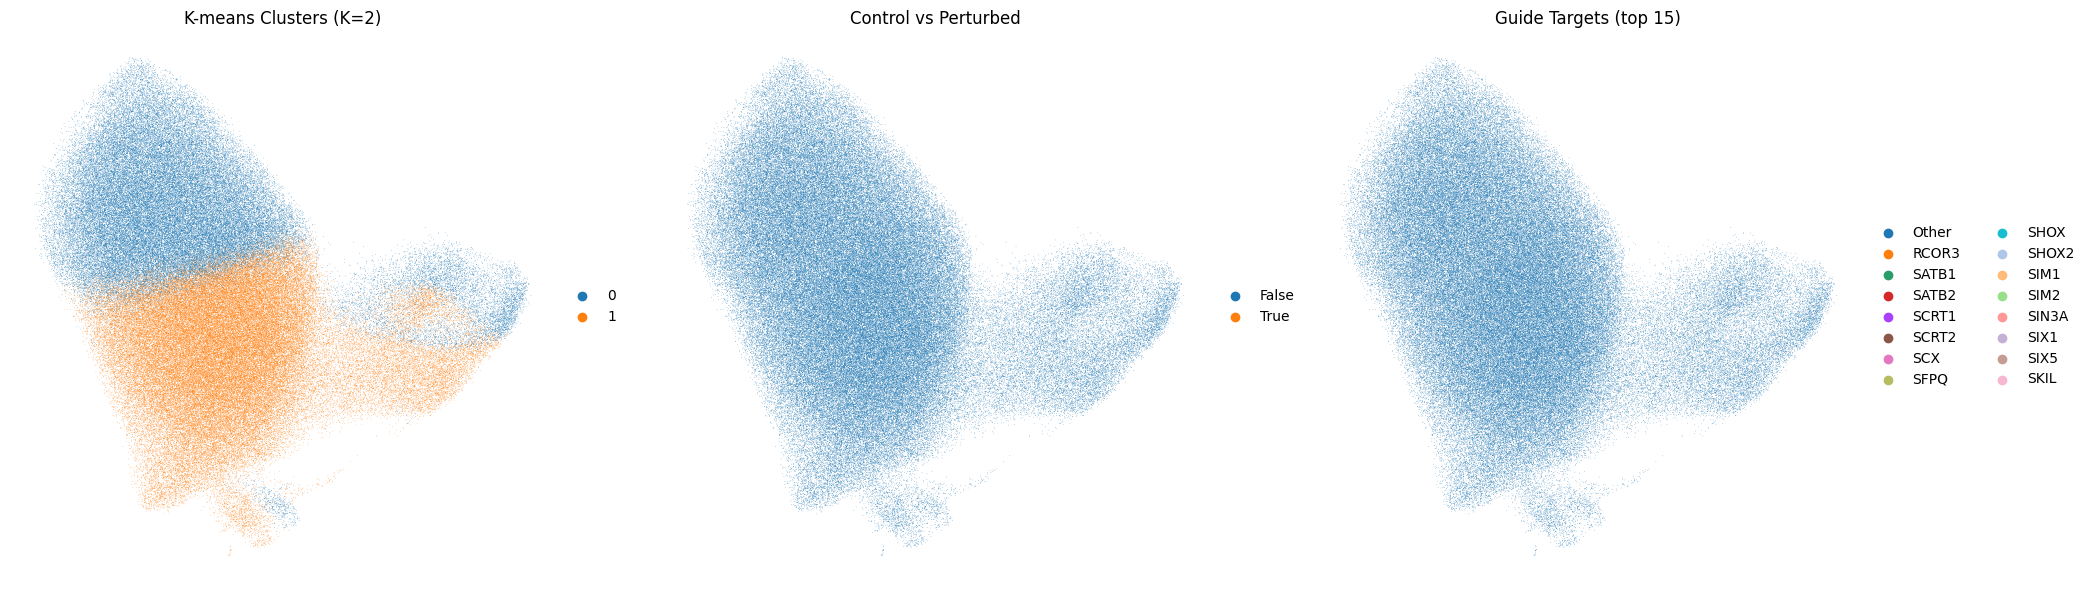

✓ Saved: analysis_k2_composition.png


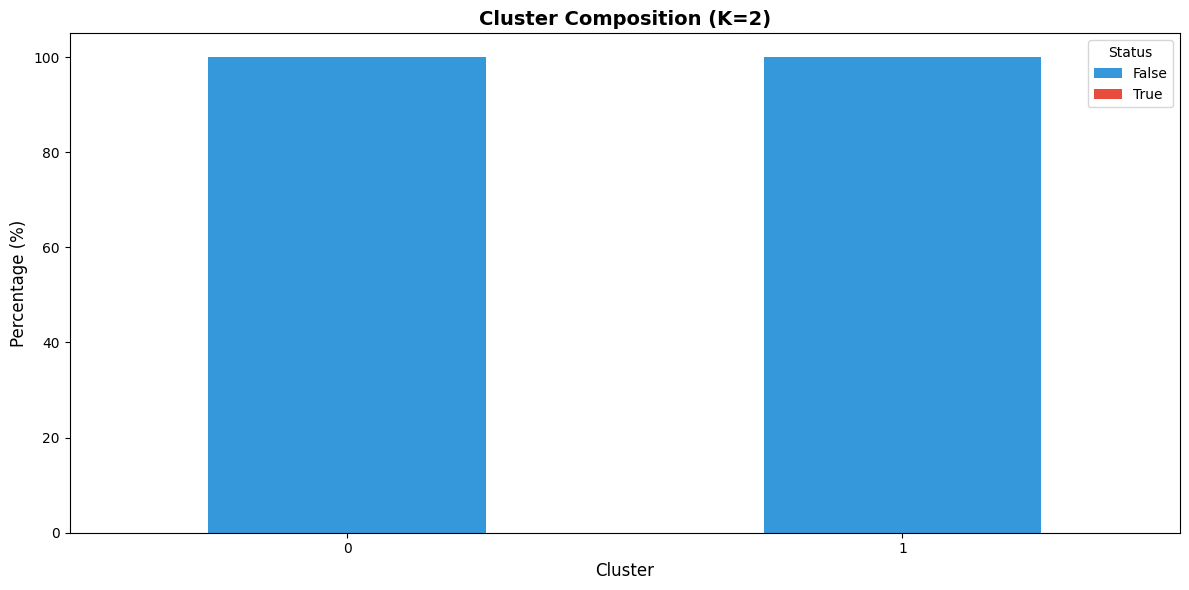


CLUSTERING SUMMARY (K=2)

Cluster sizes:
  Cluster 0: 75806 cells (44.3%)
  Cluster 1: 95501 cells (55.7%)


KeyboardInterrupt: 

In [54]:
for k in [2, 5, 10]:
        cluster_and_visualize(
            ref_embed_path="embeddings_all.h5ad",
            n_clusters=k,
            random_state=42,
            output_prefix=f"analysis"
        )

### Standard HVGs

In [56]:
# For standard HVGs
ref_embed_hvgs = embed_and_save(
    adata_hvg_standard,
    model_dir=MODEL_DIR,
    out_path="embeddings_standard_3000_stratified.h5ad",
    ref_embed_path="embeddings_standard_3000_stratified.h5ad"  
)

Found existing embedding file: embeddings_standard_3000_stratified.h5ad
Loading and validating...

Validation results:
  ✓ Found embeddings: (171307, 512)
  ✓ Cell count matches: 171307
  ✓ All expected obs columns present

✓ Using cached embeddings!


In [44]:
ref_embed_hvgs = compute_dimensionality_reduction(
        ref_embed_path="embeddings_standard_3000_stratified.h5ad",
        n_neighbors=15,
        random_state=42
    )

Computing UMAP dimensionality reduction...
  ✓ UMAP computed
✓ Saved to: embeddings_standard_3000_stratified.h5ad


Computing K-means with 2 clusters...
✓ Saved: analysis_k2_umap.png


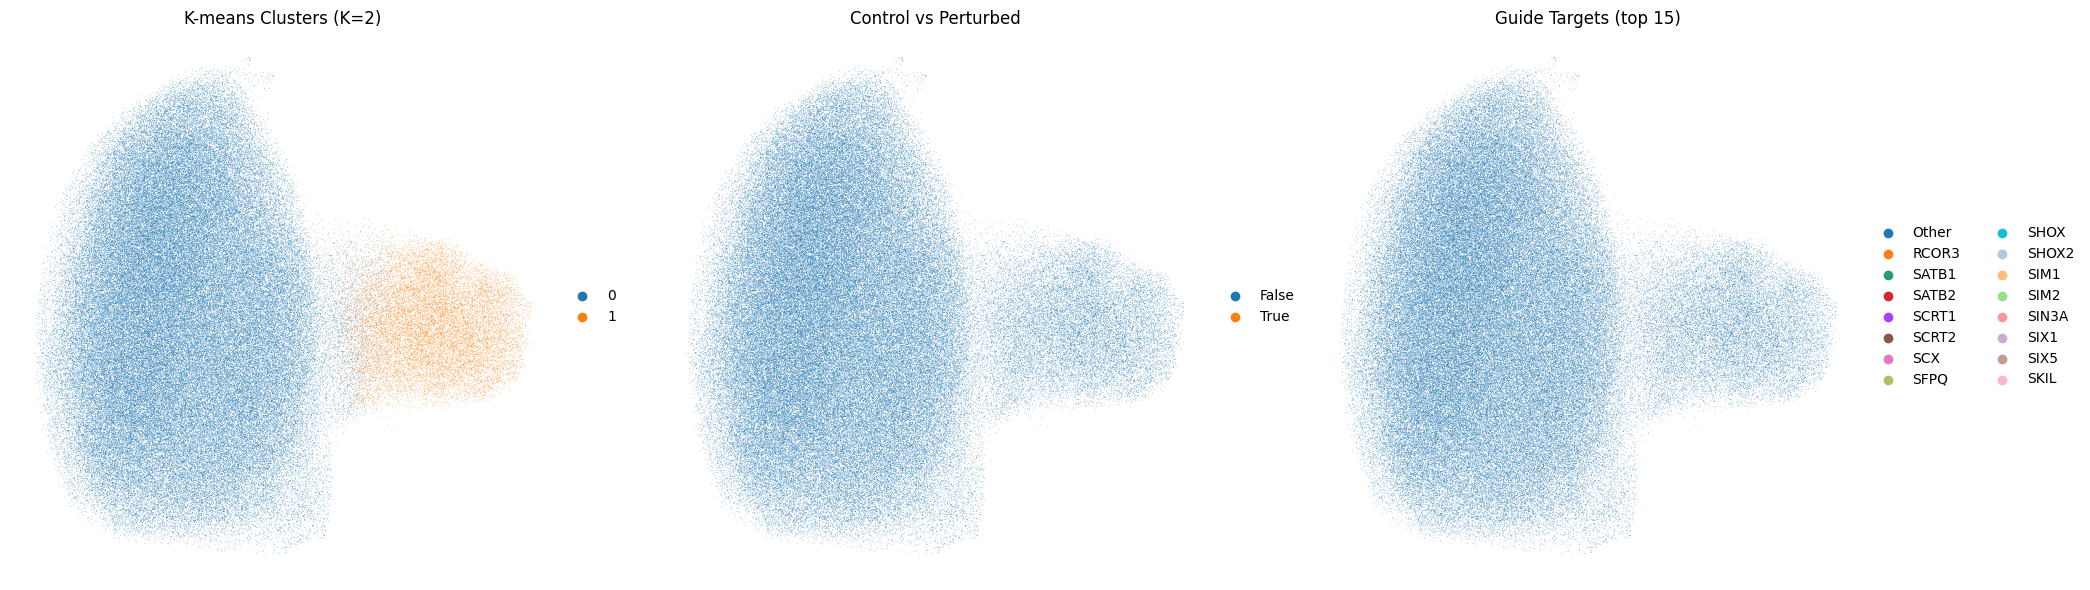

✓ Saved: analysis_k2_composition.png


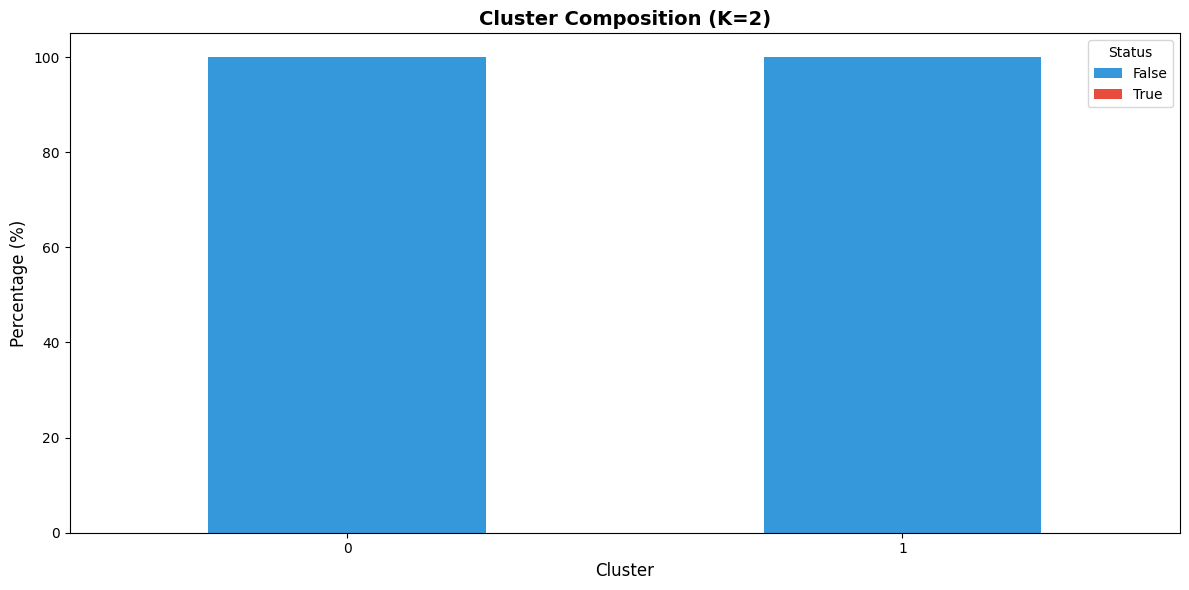


CLUSTERING SUMMARY (K=2)

Cluster sizes:
  Cluster 0: 153341 cells (89.5%)
  Cluster 1: 17966 cells (10.5%)

Silhouette Score: -0.011 (Poor separation)
Average Cluster Purity: 0.999 (High purity ✓)

Overall distribution:
  False: 171216 cells (99.9%)
  True: 91 cells (0.1%)

Top 10 guide targets:
  RCOR3: 107 cells (0.1%)
  SKIL: 107 cells (0.1%)
  SIX5: 107 cells (0.1%)
  SIX1: 107 cells (0.1%)
  SIN3A: 107 cells (0.1%)
  SIM2: 107 cells (0.1%)
  SIM1: 107 cells (0.1%)
  SHOX2: 107 cells (0.1%)
  SHOX: 107 cells (0.1%)
  SFPQ: 107 cells (0.1%)

Computing K-means with 5 clusters...
✓ Saved: analysis_k5_umap.png


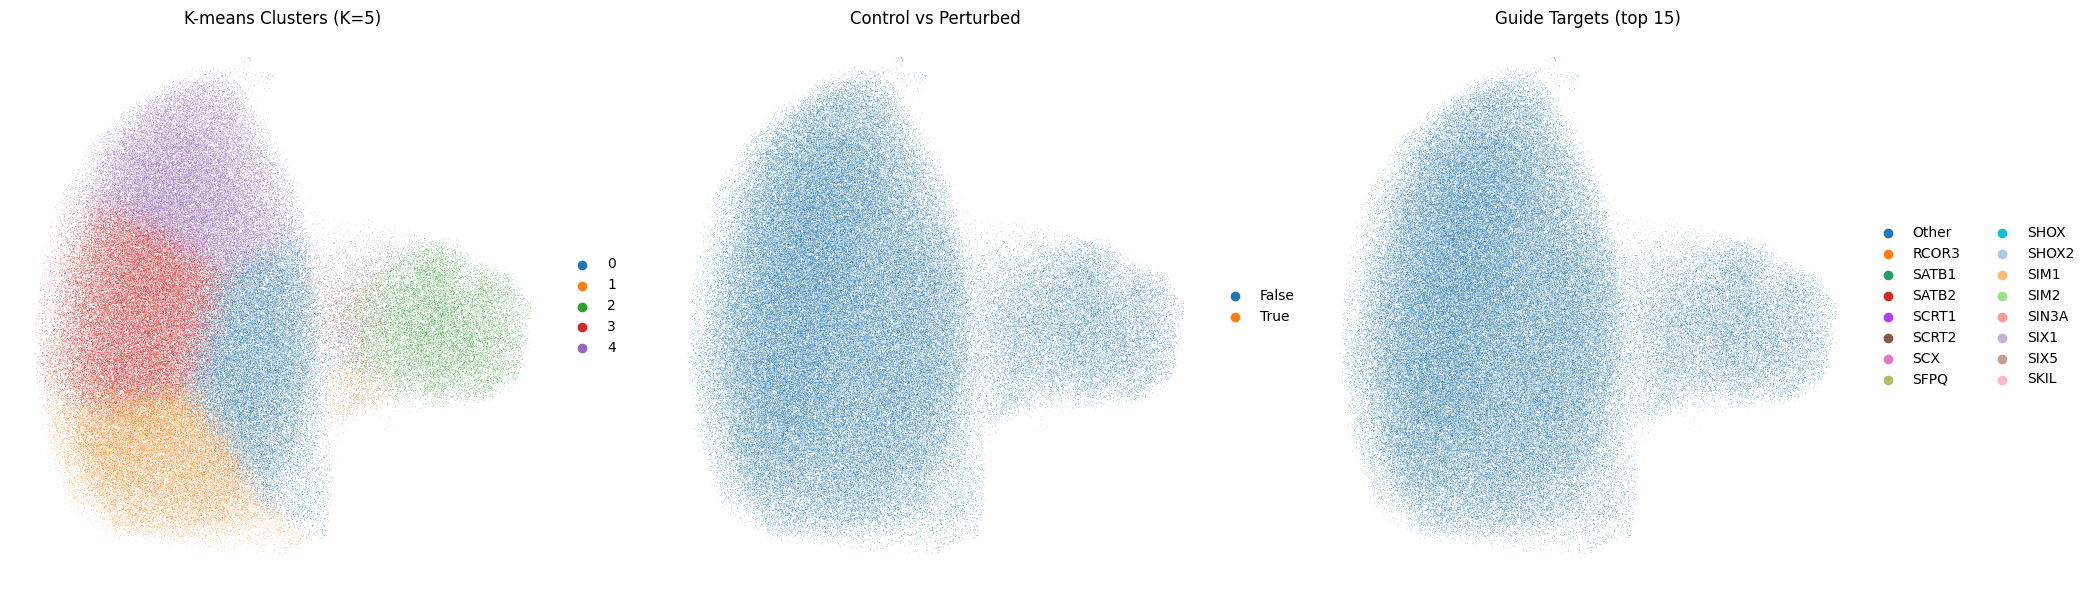

✓ Saved: analysis_k5_composition.png


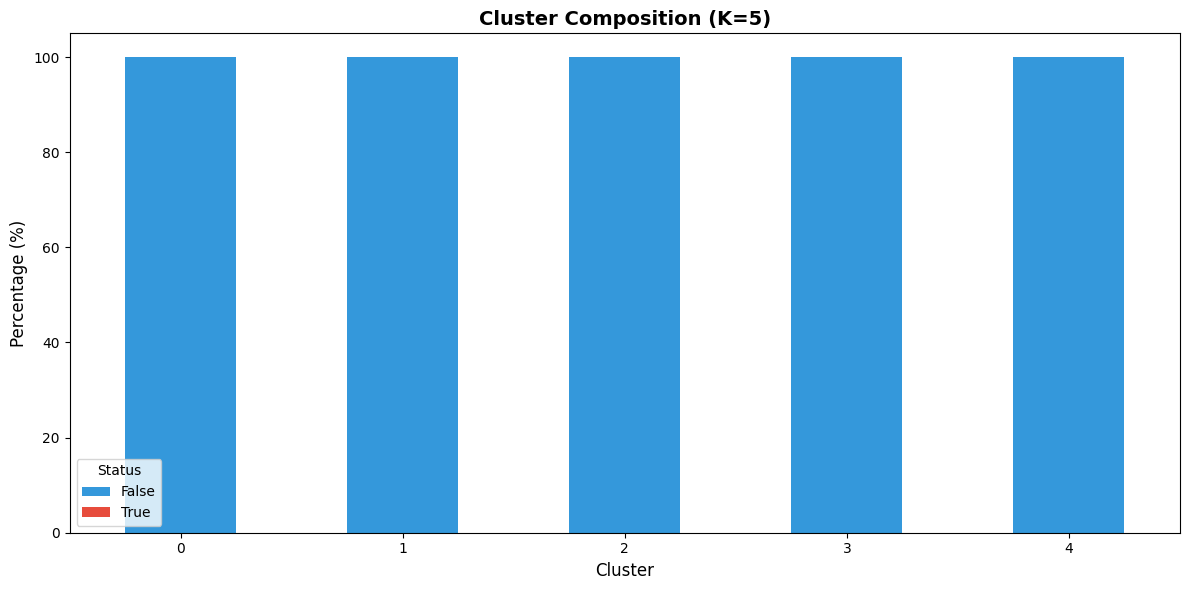


CLUSTERING SUMMARY (K=5)

Cluster sizes:
  Cluster 0: 36159 cells (21.1%)
  Cluster 1: 30532 cells (17.8%)
  Cluster 2: 16236 cells (9.5%)
  Cluster 3: 48831 cells (28.5%)
  Cluster 4: 39549 cells (23.1%)

Silhouette Score: -0.011 (Poor separation)
Average Cluster Purity: 0.999 (High purity ✓)

Overall distribution:
  False: 171216 cells (99.9%)
  True: 91 cells (0.1%)

Top 10 guide targets:
  RCOR3: 107 cells (0.1%)
  SKIL: 107 cells (0.1%)
  SIX5: 107 cells (0.1%)
  SIX1: 107 cells (0.1%)
  SIN3A: 107 cells (0.1%)
  SIM2: 107 cells (0.1%)
  SIM1: 107 cells (0.1%)
  SHOX2: 107 cells (0.1%)
  SHOX: 107 cells (0.1%)
  SFPQ: 107 cells (0.1%)

Computing K-means with 10 clusters...
✓ Saved: analysis_k10_umap.png


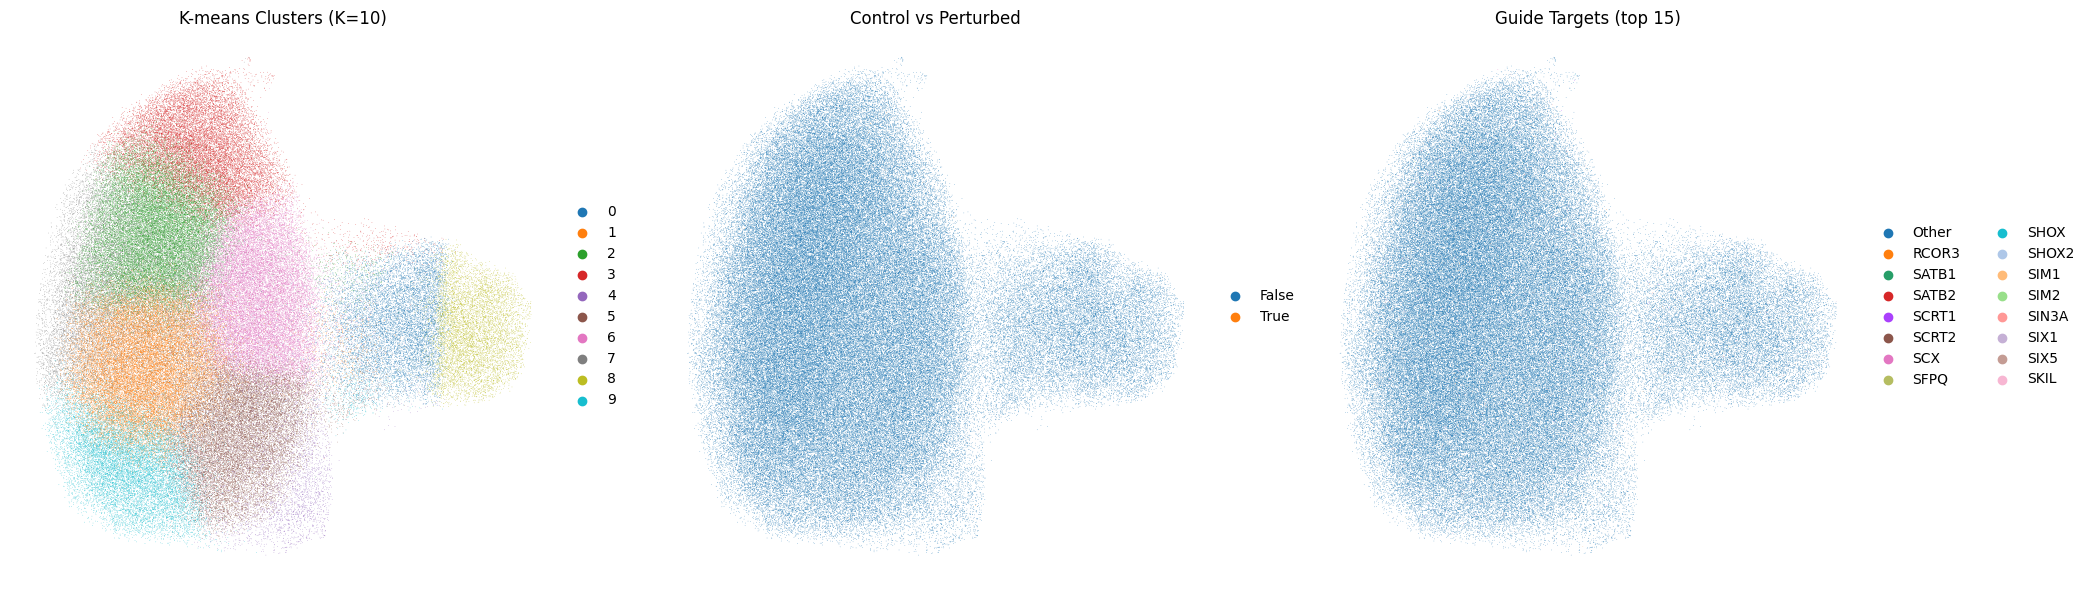

✓ Saved: analysis_k10_composition.png


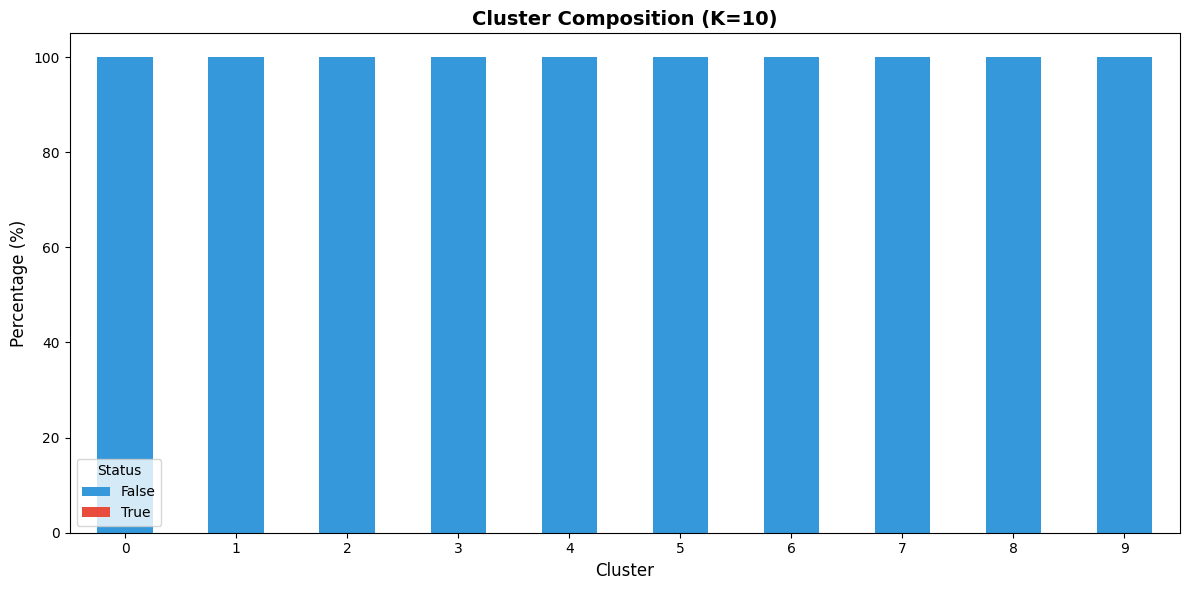


CLUSTERING SUMMARY (K=10)

Cluster sizes:
  Cluster 0: 10777 cells (6.3%)
  Cluster 1: 26812 cells (15.7%)
  Cluster 2: 25325 cells (14.8%)
  Cluster 3: 18054 cells (10.5%)
  Cluster 4: 4476 cells (2.6%)
  Cluster 5: 19776 cells (11.5%)
  Cluster 6: 24810 cells (14.5%)
  Cluster 7: 18819 cells (11.0%)
  Cluster 8: 7692 cells (4.5%)
  Cluster 9: 14766 cells (8.6%)


KeyboardInterrupt: 

In [45]:
for k in [2, 5, 10]:
        cluster_and_visualize(
            ref_embed_path="embeddings_standard_3000_stratified.h5ad",
            n_clusters=k,
            random_state=42,
            output_prefix=f"analysis"
        )

Computing UMAP dimensionality reduction...
  ✓ UMAP computed
✓ Saved to: embeddings_standard_3000_stratified.h5ad
Saved new UMAP to embeddings_standard_3000_stratified_5.h5ad
Computing K-means with 10 clusters...
✓ Saved: analysis_5_k10_umap.png


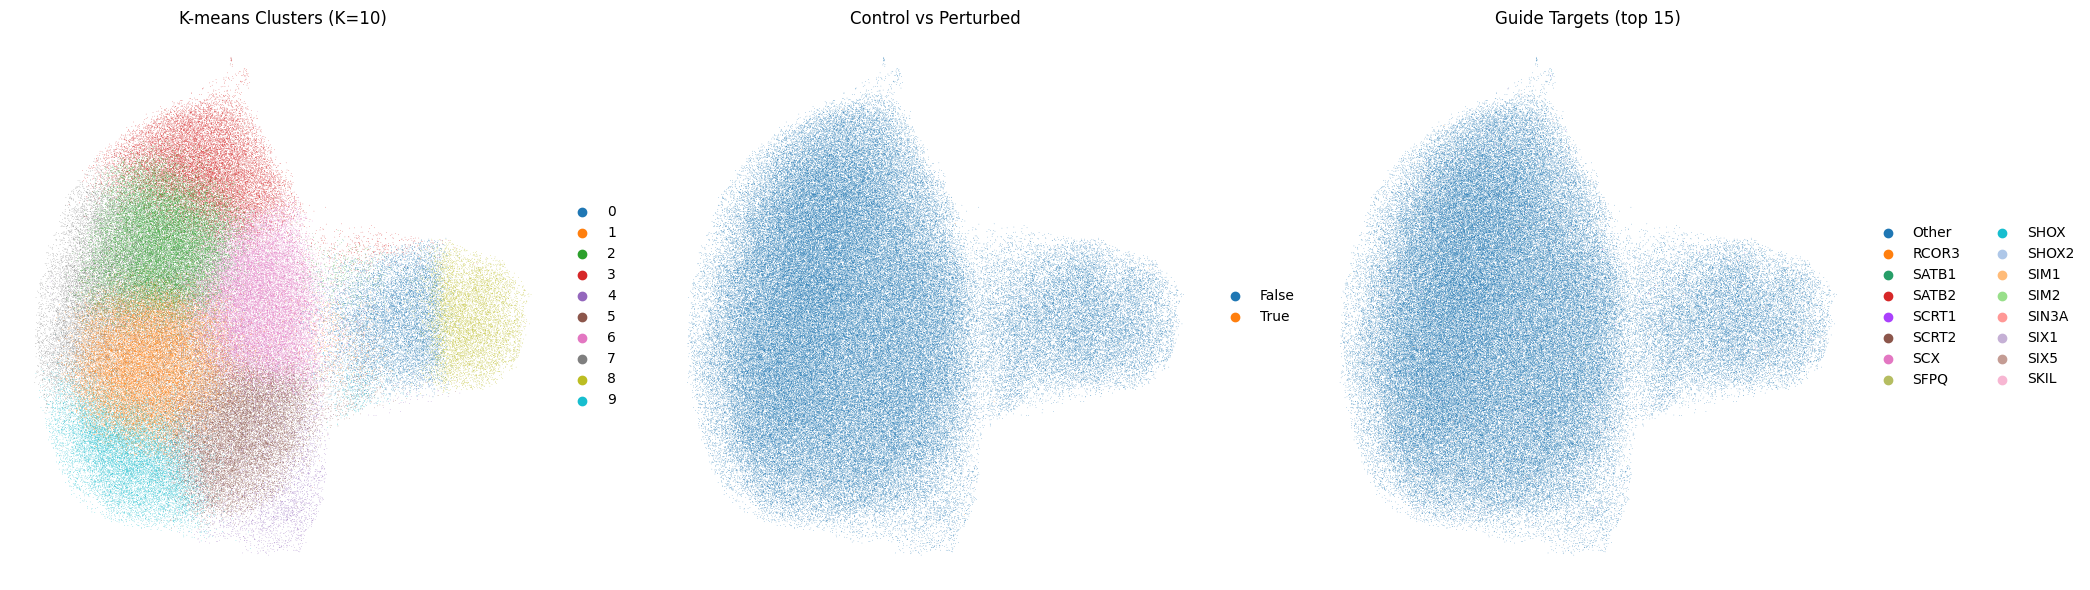

✓ Saved: analysis_5_k10_composition.png


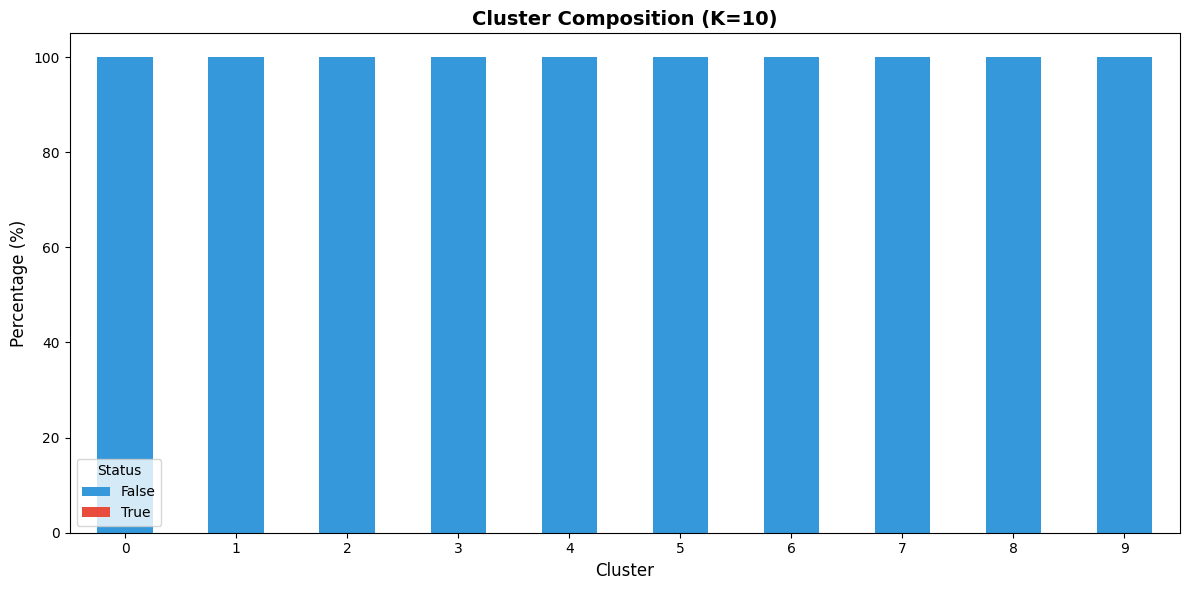


CLUSTERING SUMMARY (K=10)

Cluster sizes:
  Cluster 0: 10777 cells (6.3%)
  Cluster 1: 26812 cells (15.7%)
  Cluster 2: 25325 cells (14.8%)
  Cluster 3: 18054 cells (10.5%)
  Cluster 4: 4476 cells (2.6%)
  Cluster 5: 19776 cells (11.5%)
  Cluster 6: 24810 cells (14.5%)
  Cluster 7: 18819 cells (11.0%)
  Cluster 8: 7692 cells (4.5%)
  Cluster 9: 14766 cells (8.6%)


KeyboardInterrupt: 

In [51]:
for neighbors in [5, 10, 15]:
    base_path = "embeddings_standard_3000_stratified.h5ad"
    output_path = f"embeddings_standard_3000_stratified_{neighbors}.h5ad"

    ref_embed_hvgs = compute_dimensionality_reduction(
        ref_embed_path=base_path,  # always read from the same input file
        n_neighbors=neighbors,
        random_state=42,
        force_recompute=True
    )

    # Save to a new file so each neighbor setting is preserved
    ref_embed_hvgs.write(output_path)
    print(f"Saved new UMAP to {output_path}")

    cluster_and_visualize(
        ref_embed_path=output_path,
        n_clusters=10,
        random_state=42,
        output_prefix=f"analysis_{neighbors}"
    )

### Forced HVGs

In [ ]:
ref_embed_forced = embed_and_save(
    adata_hvg_force,
    model_dir=MODEL_DIR,
    out_path="embeddings_forced_3000_stratified.h5ad",
    ref_embed_path="embeddings_forced_3000_stratified.h5ad"  
)

In [ ]:
ref_embed_forced = compute_dimensionality_reduction(
        ref_embed_path="embeddings_forced_3000_stratified.h5ad",
        n_neighbors=15,
        random_state=42
    )

In [ ]:
for k in [2, 5, 10]:
        cluster_and_visualize(
            ref_embed_path="embeddings_forced_3000_stratified.h5ad",
            n_clusters=k,
            random_state=42,
            output_prefix=f"analysis"
        )